In [ ]:
from abc import ABC, abstractmethod
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set number of machines
k = 10

In [ ]:
class ArcadeMachine:
  def __init__(self, q_star):
    self.q_star = q_star

  def play(self):
      # Returns a reward sampled around the true value
      return np.random.normal(self.q_star, 1.0)

In [ ]:
class Environment:
  def __init__(self, q_stars):
    self.machines = [ArcadeMachine(q_star) for q_star in q_stars]
    self.num_machines = len(q_stars)

  def play(self, action):
    return self.machines[action].play()

In [ ]:
q_stars = [0.5, -0.2, 1.3, 0.0, -1.1, 0.9, 0.25, -0.75, 0.6, -0.4]

environment = Environment(q_stars)

In [ ]:
num_episodes = 500
total_steps = 1000

In [ ]:
class Agent(ABC):
    def __init__(self):
      self.num_machines = environment.num_machines
      self.Q = torch.zeros(self.num_machines)
      self.N = torch.zeros(self.num_machines)
      self.reward_history = [[] for _ in range(self.num_machines)]
      self.reward_log = np.zeros((num_episodes, total_steps))

    def __str__(self):
      return self.label

    def reset(self):
      self.Q = torch.zeros(self.num_machines)
      self.N = torch.zeros(self.num_machines)

    @abstractmethod
    def select_action(self):
        pass

    def update(self, action, reward, episode_idx, step_idx):
      self.N[action] +=1
      self.Q[action] += (1/ self.N[action]) * (reward - self.Q[action])
      self.reward_history[action].append(reward)
      self.reward_log[episode_idx,step_idx] = reward

In [ ]:
class EpsilonGreedyAgent(Agent):
  def __init__(self, epsilon):
    super().__init__()
    self.epsilon = epsilon
    self.label = f"ε = {epsilon:.2f}"

  def select_action(self):
    if np.random.rand() < self.epsilon:
      # explore
      return np.random.randint(self.num_machines)
    else:
      # exploit
      return torch.argmax(self.Q).item()

In [ ]:
class OptimisticGreedyAgent(Agent):
  def __init__(self, initial_action):
    super().__init__(self)
    self.Q = torch.full((self.num_machines,), float(initial_action))

  def select_action(self):
    return torch.argmax(self.Q).item()

In [ ]:
# In progress of creation
class GradientBanditAgent(Agent):
  def __init__(self):
    super().__init__(self)

In [ ]:
class UCBAgent(Agent):
  def __init__(self, c):
     super().__init__()
     self.c = c
     self.t = 1
     self.label = f"UCB c = {c}"

  def select_action(self):
    ucb_scores = torch.zeros(self.num_machines)
    for action in range(self.num_machines):
      if self.N[action] == 0:
        ucb_scores[action] = float('inf')
      else:
        ucb_scores[action] = self.Q[action] + self.c * torch.sqrt(np.log(self.t) / self.N[action])
    return torch.argmax(ucb_scores).item()

  def update(self, action, reward, episode_idx, step_idx):
    super().update(action, reward, episode_idx, step_idx)
    self.t += 1

In [ ]:
agents = [
    EpsilonGreedyAgent(epsilon=0),
    EpsilonGreedyAgent(epsilon=0.01),
    EpsilonGreedyAgent(epsilon=0.1),
    UCBAgent(c=2)
]

In [ ]:
for episode_idx in range(num_episodes):
  for agent in agents:
    agent.reset()
    for step_idx in range(total_steps):
        action = agent.select_action()
        reward = environment.play(action)
        agent.update(action, reward, episode_idx, step_idx)

In [ ]:
def plot_violin(data, title="Violin Plot", xlabel="X-Axis", ylabel="Y-Axis"):
  plt.figure(figsize=(10, 6))
  sns.violinplot(data=data)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

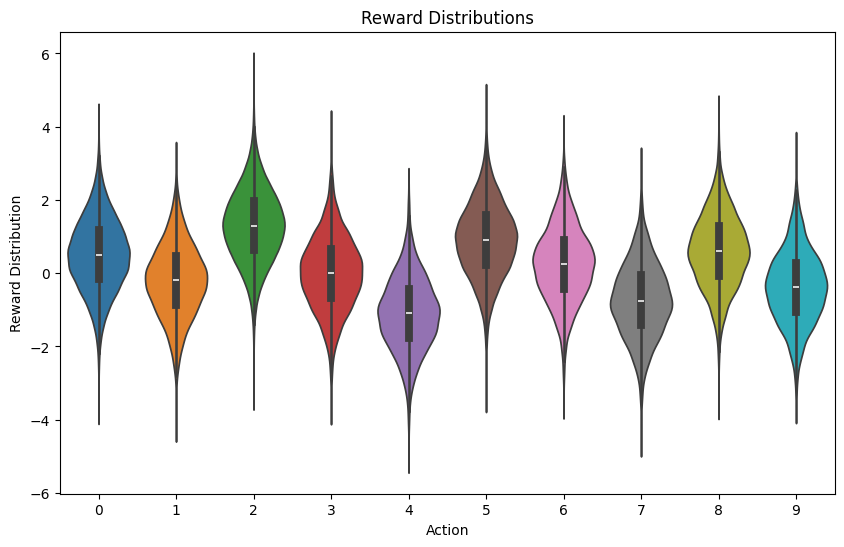

In [ ]:
plot_violin(agents[2].reward_history, "Reward Distributions", "Action", "Reward Distribution")

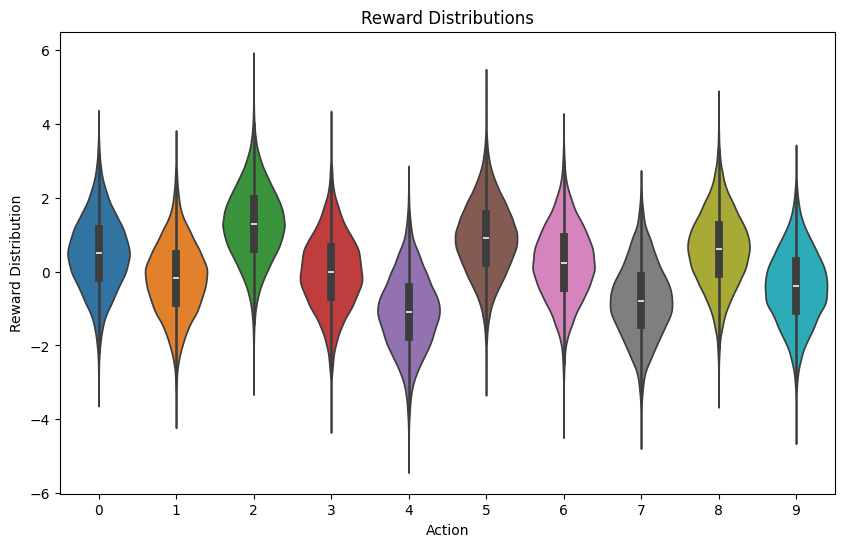

In [ ]:
plot_violin(agents[3].reward_history, "Reward Distributions", "Action", "Reward Distribution")

In [ ]:
def print_best_action(agent):
    best_action = torch.argmax(agent.Q).item()
    best_value = agent.Q[best_action].item()
    print(f"Best action (arm) estimated: {best_action}")
    print(f"Estimated value Q(a): {best_value:.3f}")

In [ ]:
print_best_action(agents[2])

Best action (arm) estimated: 2
Estimated value Q(a): 1.329


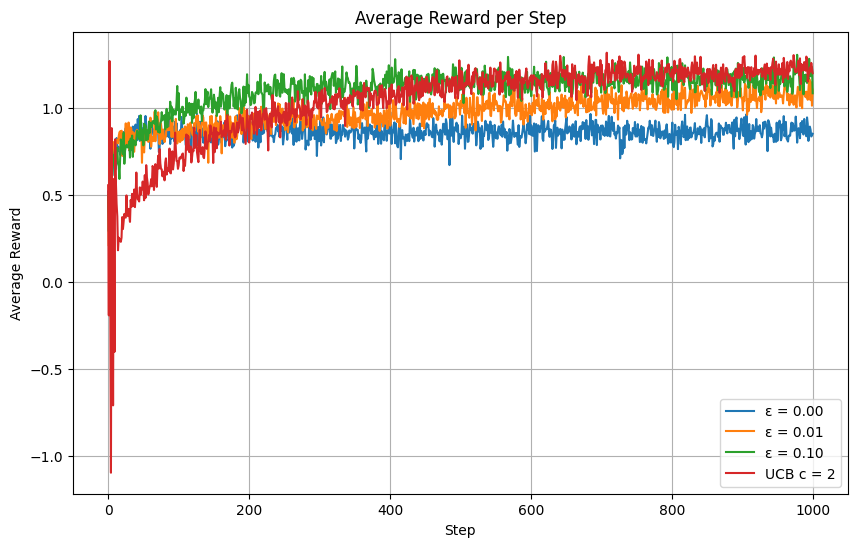

In [ ]:
plt.figure(figsize=(10, 6))

for agent in agents:
    reward_avg = np.mean(agent.reward_log, axis=0)
    plt.plot(range(agent.reward_log.shape[1]), reward_avg, label=agent.label)

plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.title("Average Reward per Step")
plt.legend()
plt.grid(True)
plt.show()